In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
import numpy as np
import torch

import matplotlib.pyplot as plt
import scipy.ndimage as scimage
from skimage.transform import warp
import torch.nn as nn
from skimage import io

from skimage.transform import rescale, resize
from skimage.util import img_as_ubyte
from PIL import Image
from torchvision import models
import torchvision.transforms as T



import scipy.sparse.linalg

np.set_printoptions(precision=2, suppress=True)
torch.set_printoptions(precision=2, sci_mode=False)

!pip install opencv-contrib-python==4.4.0.44
import cv2
print (cv2 .__version__)

!pip install xmltodict
import xmltodict
from scipy.spatial.transform import Rotation 

np.set_printoptions(precision=4, suppress=True)
torch.set_printoptions(precision=4, sci_mode=False)

4.4.0


In [27]:

'''
------------------ HELPER FUNCTIONS -------------------
'''

# Compute essential and fundamental matrices from R, T, K matrices that are returned from calibration
def compute_essential_fundamental_matrices (R_left, T_left, K_left, R_right, T_right, K_right) :
    ''' Given the calibrations of each of the cameras with respect to the world, it return essential (E)
    and fundamental (F) matrices. '''
    R_lr =  R_right @ np.transpose(R_left) # rotation matrix to align a pt in left image to right image
    T_r =  T_right - R_lr @ T_left   # translation vector to the left camera from the right camera, with respect to the right camera 

    '''Epipolar constraint matrix (Essential matrix)'''
    E = np.zeros((3,3))
    E[:,0] = np.cross(T_r, R_lr[:,0]) # essential matrix
    E[:,1] = np.cross(T_r, R_lr[:,1])
    E[:,2] = np.cross(T_r, R_lr[:,2])

    ''' Fundamental matrices -- to express in terms of array coordinates '''
    K_left_inv = np.linalg.inv(K_left)
    K_right_inv = np.linalg.inv(K_right)
    F = np.transpose(K_right_inv) @ E @ K_left_inv  # Fundamental matrix -- includes intrinsic parameters
    return (E, F, R_lr, T_r)


# Code to compute epipolar lines corresponding to a given point in the left image.

def epipolar_lines (F, point_left, image_left_size, image_right_size) :
    '''
    F is 3 by 3 fundamental matrix
    point_left is 2 by 1 vector of point in the left image
    image_left_size, image_right_size are the sizes of the two images
    It returns pairs of corresponding epiolar lines 
    (i) epipolar line passing through the point in the left image and
    (ii) epipolar line in the right image corresponding to the point in the left image.
    '''

    pts = np.row_stack ((point_left, [1])) # homogenous represention

    line_right = F @ pts # homogenous coordinates of the epipolar line, line_right is 3 by 1

    # The following code computes a set of points on the epiolar line in the right image that can be ploted
    # Coordinates of the epipolar line on right image for the point p_right
    x_right = np.arange(0, image_right_size[1]) # uniformly spread x coordinates
    y_right = (-line_right[0]*x_right - line_right[2])/line_right[1] # corresponding y-coordinates
    
    # select only the part of the line that falls within the image
    x_right = x_right[(y_right[:] > 0),]; 
    y_right = y_right[(y_right[:] > 0),];
    x_right = x_right[(y_right[:] < image_right_size[0]),] 
    y_right = y_right[(y_right[:] < image_right_size[0]),]
    
    # The following code computes a set of points on the epiolar line in the left image that can be ploted 
    if (x_right.any()) : # if the right epiolar line is inside the image boundary
        p_right = np.array([x_right[0], y_right[0], 1]) # pick a point on the line

        line_left = p_right @ F

        # Coordinates of the epipolar line on left image for the point p_right
        x_left = np.arange(0, image_left_size[1])
        y_left = (-line_left[0]*x_left - line_left[2])/line_left[1]
        # select only the part of the line that falls within the image
        x_left = x_left[(y_left[:] > 0),]; 
        y_left = y_left[(y_left[:] > 0),];
        x_left = x_left[(y_left[:] < image_left_size[0]),] 
        y_left = y_left[(y_left[:] < image_left_size[0]),]
    
    if (x_right.any()) :
        if (x_left.any()) :
            return(x_left, y_left, x_right, y_right)
    return(np.array([]), np.array([]), np.array([]), np.array([]))  



def world_to_image (p, K, R, T) :
    # p is a 3D point, return the 2D image location
    x = K @ (R @ p + T)
    x /= x[2,:]
    return(x[0:2,:])


def inside_image (image, p) :
    # p is 2 by N set of points, return N, size array indicating which points are inside the image.
    insideP = (p[1,:] < image.shape[0]) * (p[0,:] < image.shape[1]) * (p[0,:] > 0) * (p[1,:] > 0)
    return(insideP)


def DLT_estimate_3D_pt_from_2D_pts (pts_2d, P) :
    ''' P: array size N by 3 by 4 of projective parameters of the N cameras.  
        pts_2D: 2 by N point locations on image 
        returns the DLT error and the 3 by 1 location of the 3D point.'''
    N = pts_2d.shape[1]
    A = np.zeros((2*N, 4))
    for j in range (N) :
        A[2*j,:]   = P[j,2,:] * pts_2d[0,j] - P[j,0,:]  # first row
        A[2*j+1,:] = P[j,2,:] * pts_2d[1,j] - P[j,1,:]  # second row
    
    vals, vecs = scipy.sparse.linalg.eigs(np.transpose(A) @ A, k=1, which='SM') # smallest eigenvalue
    #print('Minimum singular value', np.real(vals[0]))

    p = np.real(vecs).squeeze()
    p /= p[3]
    return(np.real(vals[0]),  p[0:3])
    


dtype = torch.float
device = torch.device("cpu")
#device = torch.device("cuda:0")  # Uncomment this to run on GPU
#-------------------------------------------------------------------------------
def estimate_3D_pt_2D_residual_Gauss_Newton (pts_2d, P) :
    ''' P: array size N by 3 by 4 of projective parameters of the N cameras.  
        pts_2D: 2 by N point locations on image 
        returns the DLT error and the 3 by 1 location of the 3D point.'''
    N_cameras = pts_2d.shape[1]
    P = torch.tensor(P, device = device, requires_grad=False) # perspective projection equation
    X_gt = torch.tensor(pts_2d, device = device, requires_grad=False) # non-homogenous coordinates
    h_one = torch.tensor([1], device = device, requires_grad=False) # fixed entry of the homogenous representation of a point

    def transform (X_3D): # just 3D vector representing the point
        ''' This function return the error we want to minimize by varying the input, i.e. the 3D coordinates
            It assumes that it has access to a global variable, P, which contains the projective parameters of 
            each of the cameras. P is a three dimensional matrix. The first dimension of P is the camera id.
            The next two stores the 12 camera projective parameters of the respective camera. P[j, :, :] contains
            the 12 projective parameters of the j-th camera. The dimension of P is N_cameras by 3 by 4.'''
        
        X_h = torch.cat((X_3D, h_one), 0)
        xim_h = torch.matmul(P, X_h)  # Tensor sizes -- (N by 3 by 4) @ (4 by 1) = N by 3 by 1
        xim_h = xim_h.squeeze().transpose(1, 0) # from N by 3 by 1 to 3 by N
        xim_nh = non_homogeneous (xim_h) # Tensor sizes -- 3 by N reduced to 2 by N
        #print('X_h ', X_h.shape, 'xim_h', xim_h.shape, 'xim_nh', xim_nh.shape, 'X_gt', X_gt.shape)
        Xloss =  loss(xim_nh)
        return (Xloss)  

    def non_homogeneous (X_in) :
        # X is a 3 by N matrix -- each column is a homogenenous coordinate of a point
        X_out = torch.div(X_in, X_in [2,:]) # normalized homogenous coordinates
        return(X_out [0:2,:])

    def loss (X_t) :
        # Note X_gt is not defined in this function scope
        return(X_gt - X_t)

    def SSD_fit_error (X_3D) :
        # Note X is not defined in this function scope
        Xt = transform (X_3D)
        return(torch.pow(Xt, 2).sum())

    # initialize the location estimate using DLT
    error_, X_DLT  = DLT_estimate_3D_pt_from_2D_pts (pts_2d, P)
    
    X_NLS = torch.tensor(X_DLT, device = device, requires_grad=True)

    change_in_residual = 1.0
    old_residual = torch.sqrt(SSD_fit_error(X_NLS)/N_cameras)
    #print('Initial 2D image residual: {}'.format(old_residual))

    while change_in_residual > 0.001:
        'Compute Jacobian'
        J = - torch.autograd.functional.jacobian(transform, X_NLS) # do not understand this is off by a sign?!
        # print('Jacobian shape=', J.shape, '\n Jacobian = \n', J)
        # size of J is torch.Size([2, N_data, 3]) 
        JJ = J.permute(1, 0, 2)   # N_pts by 2 by 8
        J_T = J.permute(1, 2, 0) # N_pts by 8 by 2

        'Compute A -- Hessian'
        A = torch.sum((J_T @ JJ), 0)

        'Compute residual'
        del_r = transform(X_NLS)  # rise of del_r is torch.Size([2, N_data])
        del_r = del_r.permute(1, 0)[:,:,None]  #46 by 2 by 1
        #print('Shapes A {}, J {}, JT {}, delr {}'.format(A.shape, J.shape, J_T.shape, del_r.shape))

        'Compute b vector'        
        b = torch.sum((J_T @ del_r), 0)
        #print('Jacobian=\n', J, 'A=\n', A, 'A2=\n', A2, 'b=\n', b)

        'Compute change in parameter'
        del_p = (torch.inverse(A) @ b).squeeze()
        
        'Update estimate'
        X_NLS  = X_NLS + del_p

        'Compute new residual and percentage change in residual'
        new_residual = torch.sqrt(SSD_fit_error(X_NLS)/N_cameras)
        change_in_residual = (old_residual - new_residual)/old_residual
        old_residual = new_residual
        
        #print('Residual: {}'.format(new_residual))
    
    X_NLS = X_NLS.detach().cpu().numpy()
    X_NLS = X_NLS[:, None]
    return(new_residual, X_NLS)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:112: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:112: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:125: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in true_divide
/usr/local/l

height:  170.8658013442331


Text(0.5, 1.0, 'cam 7')

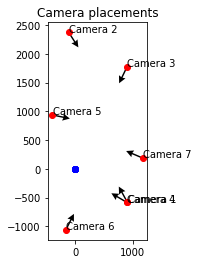

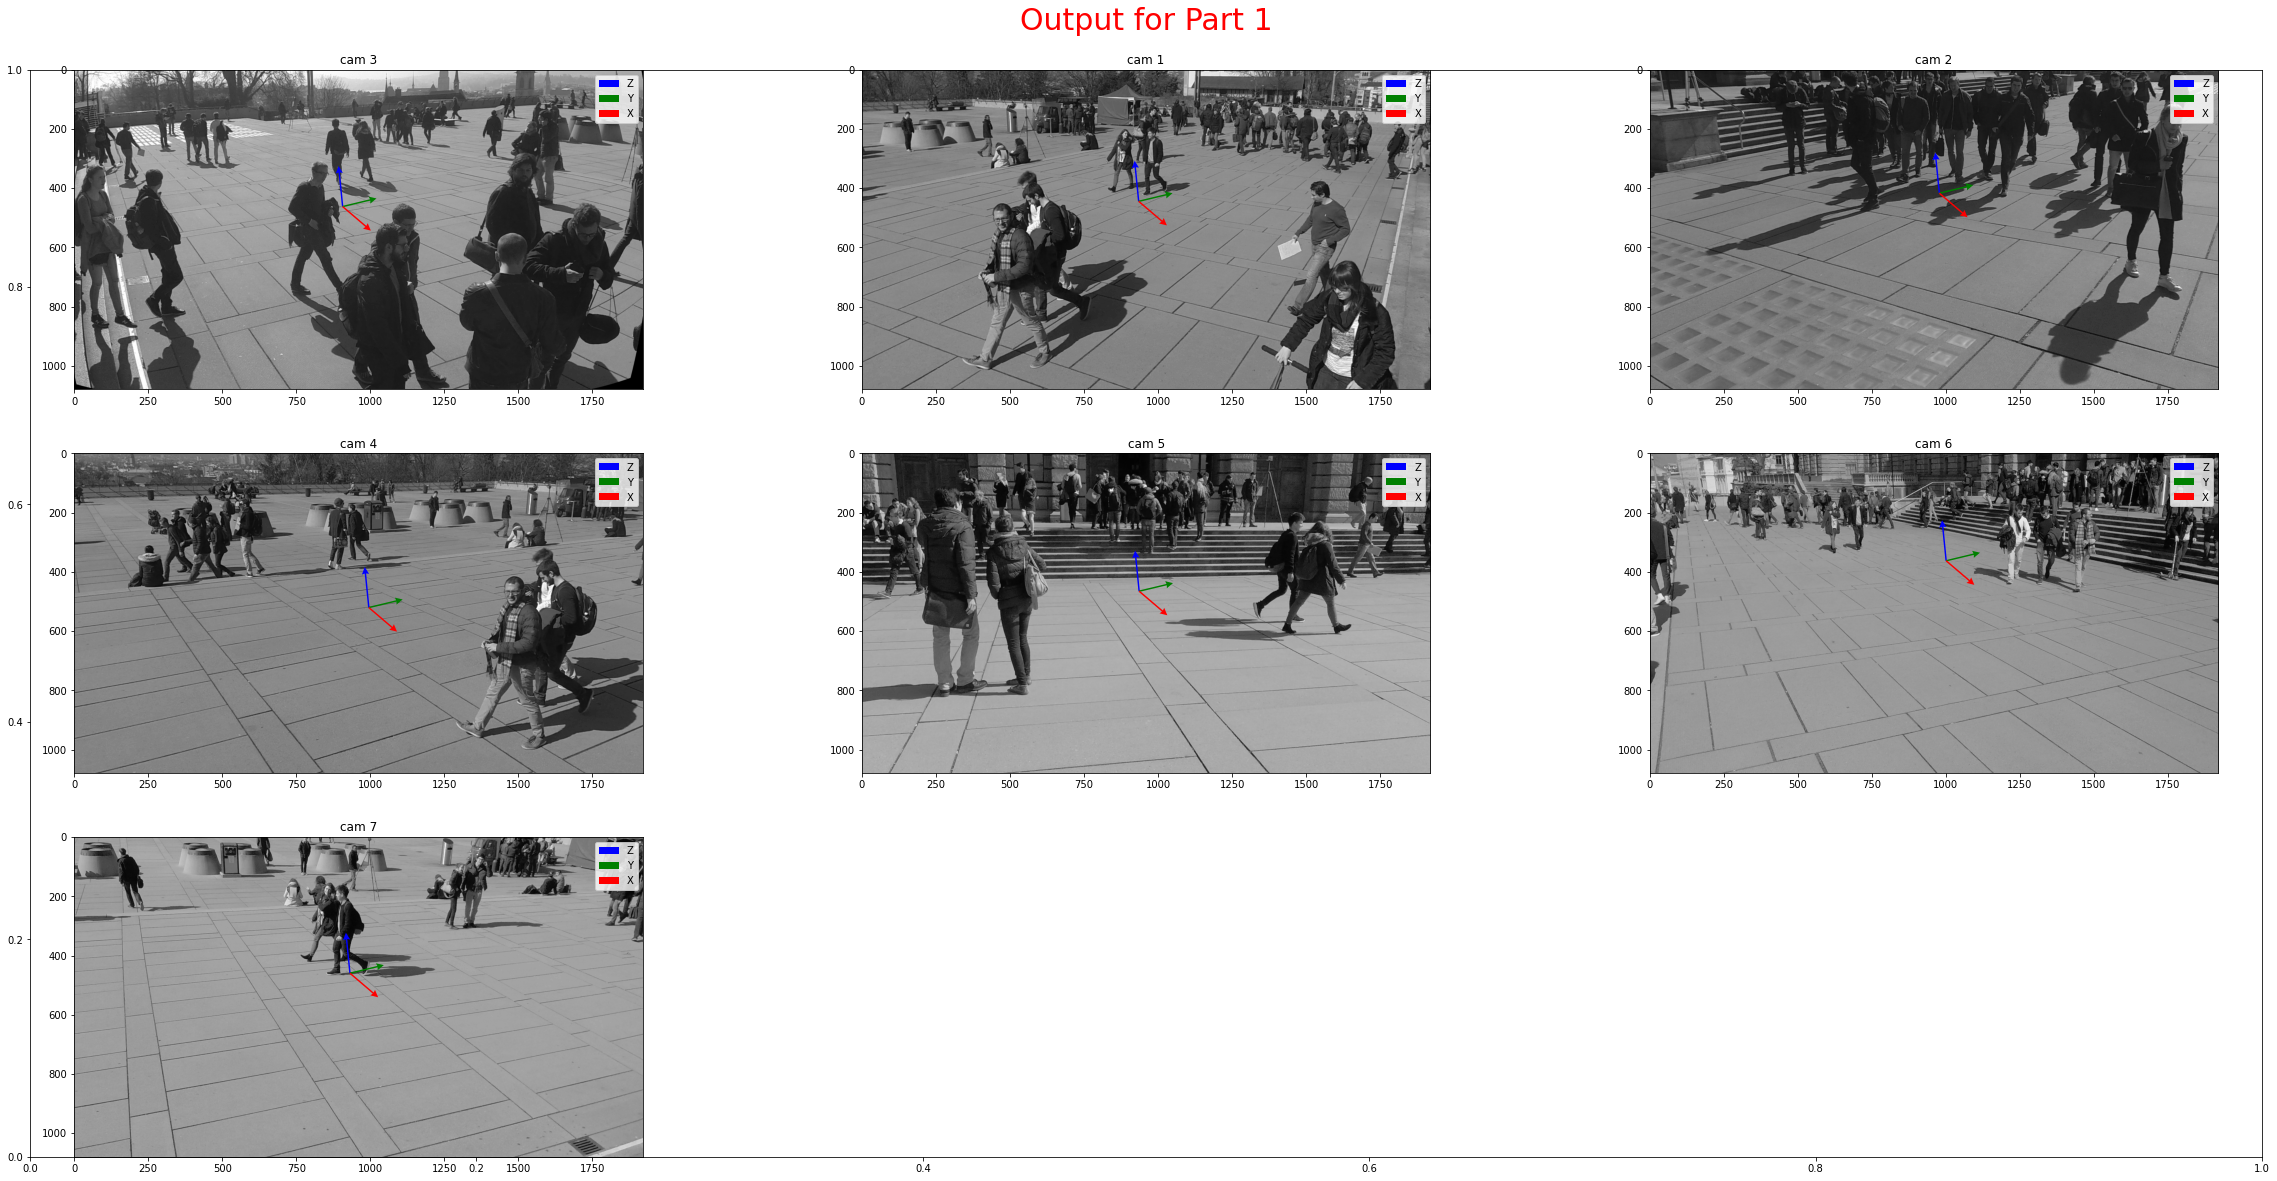

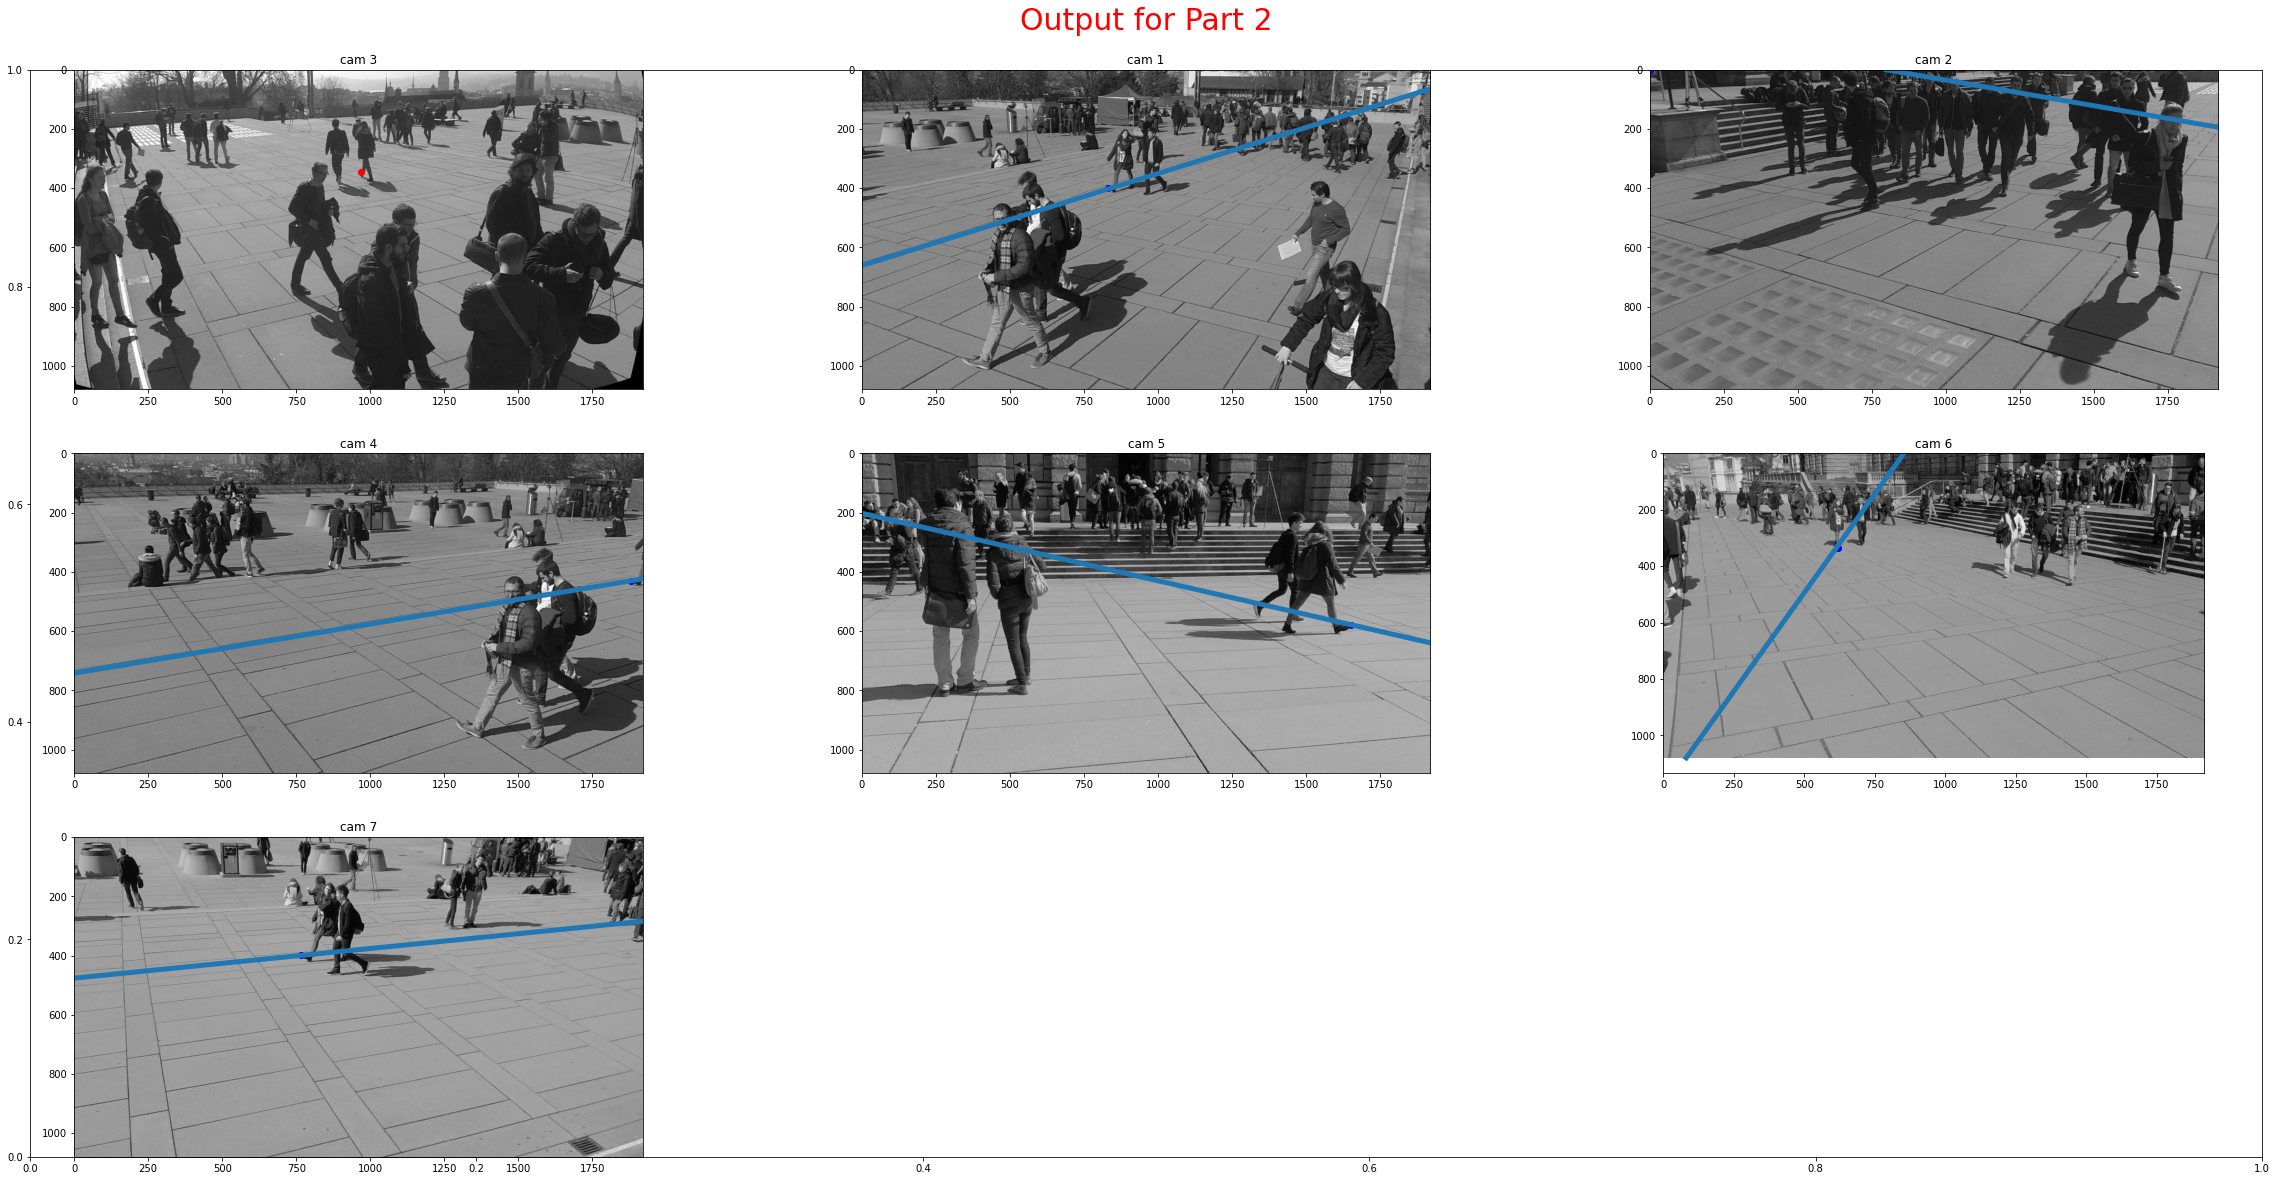

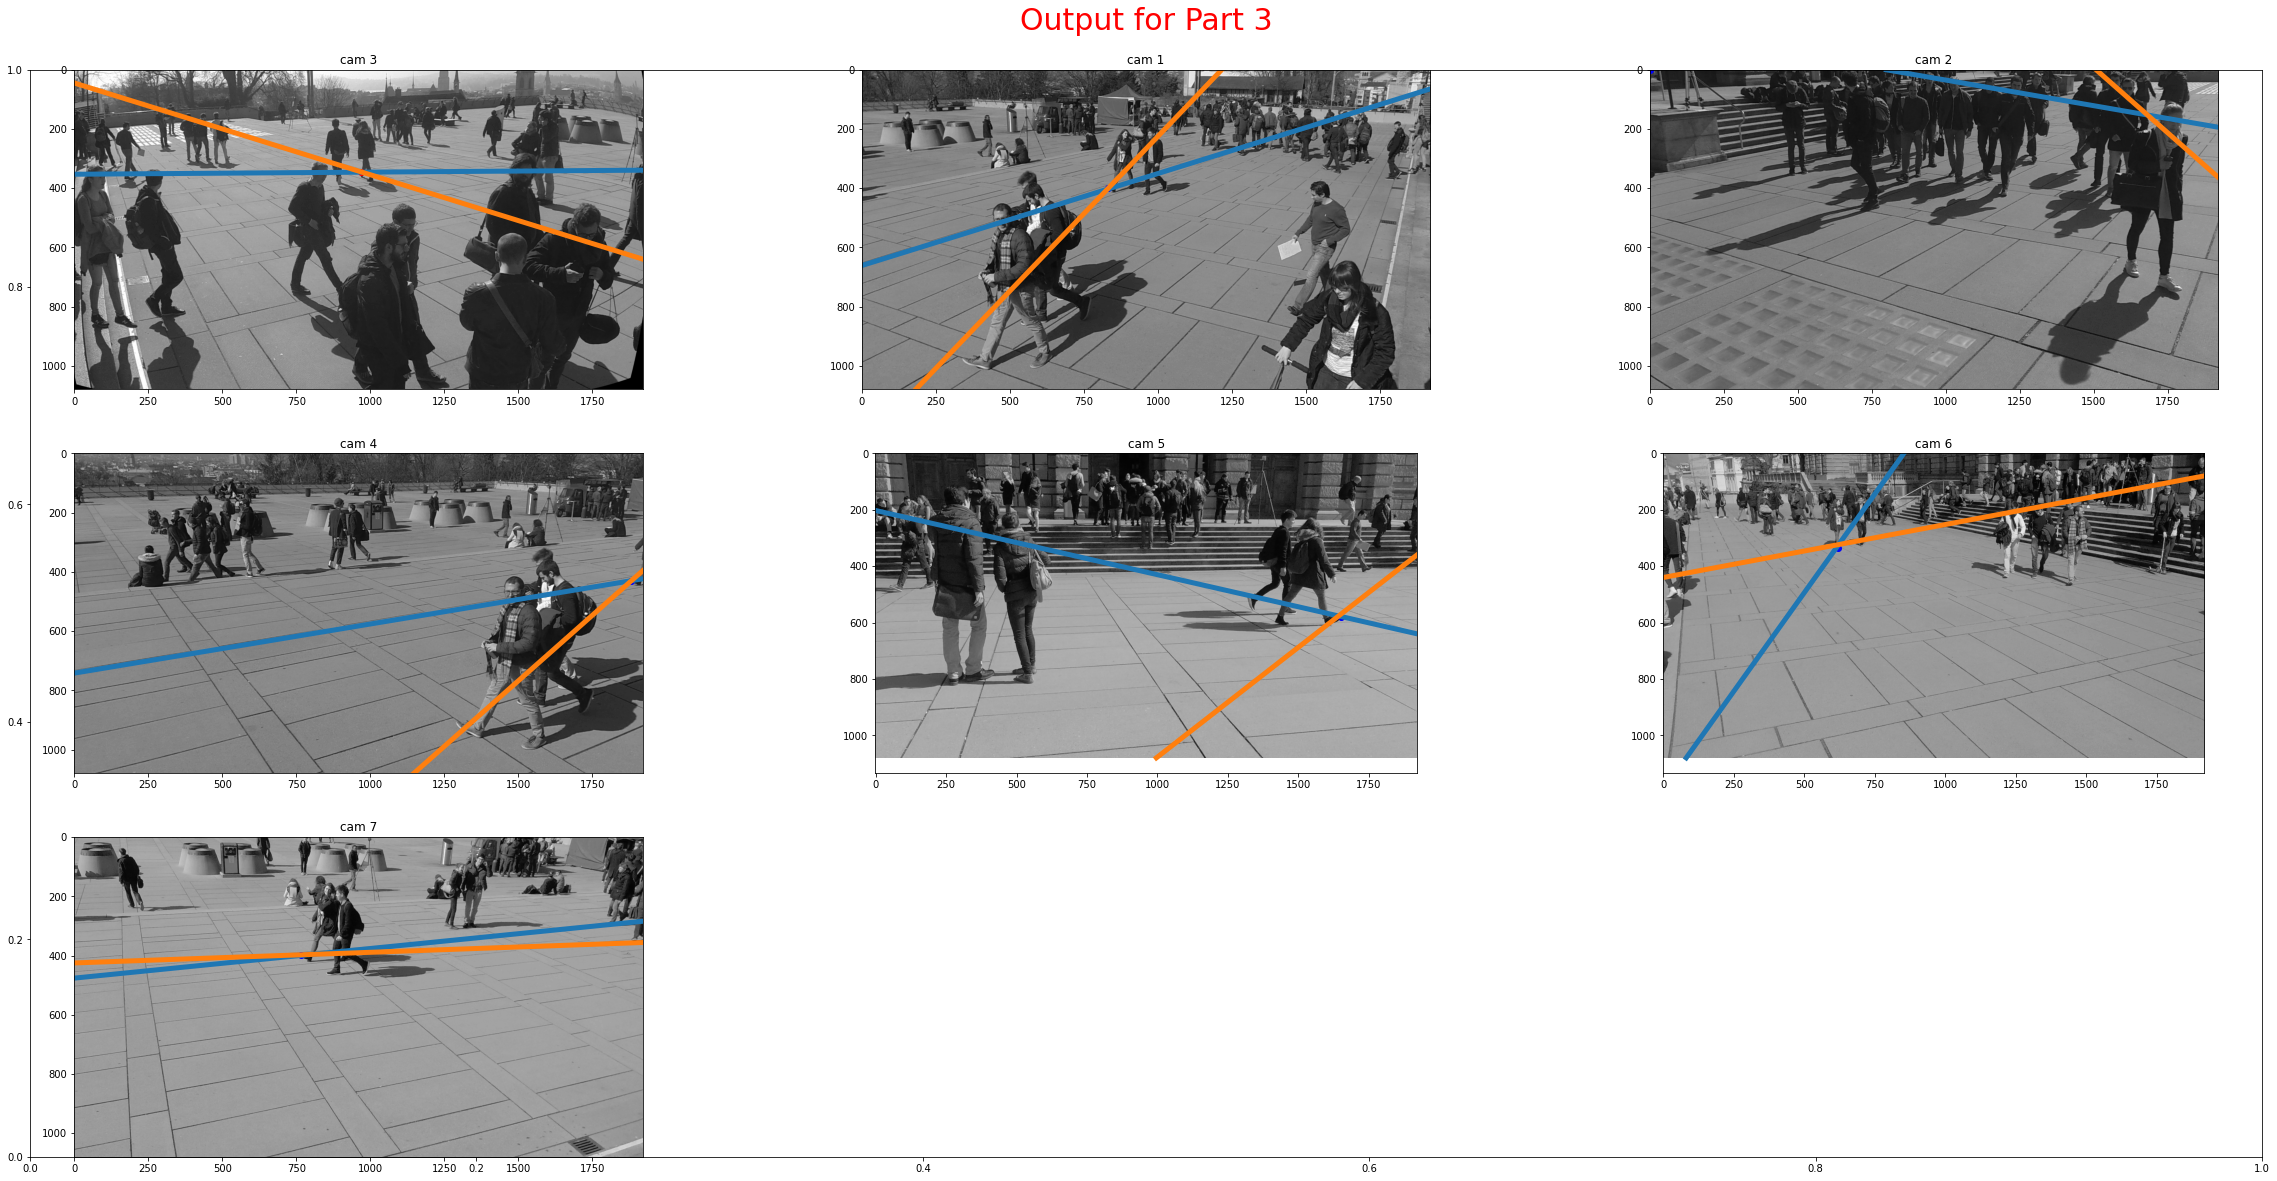

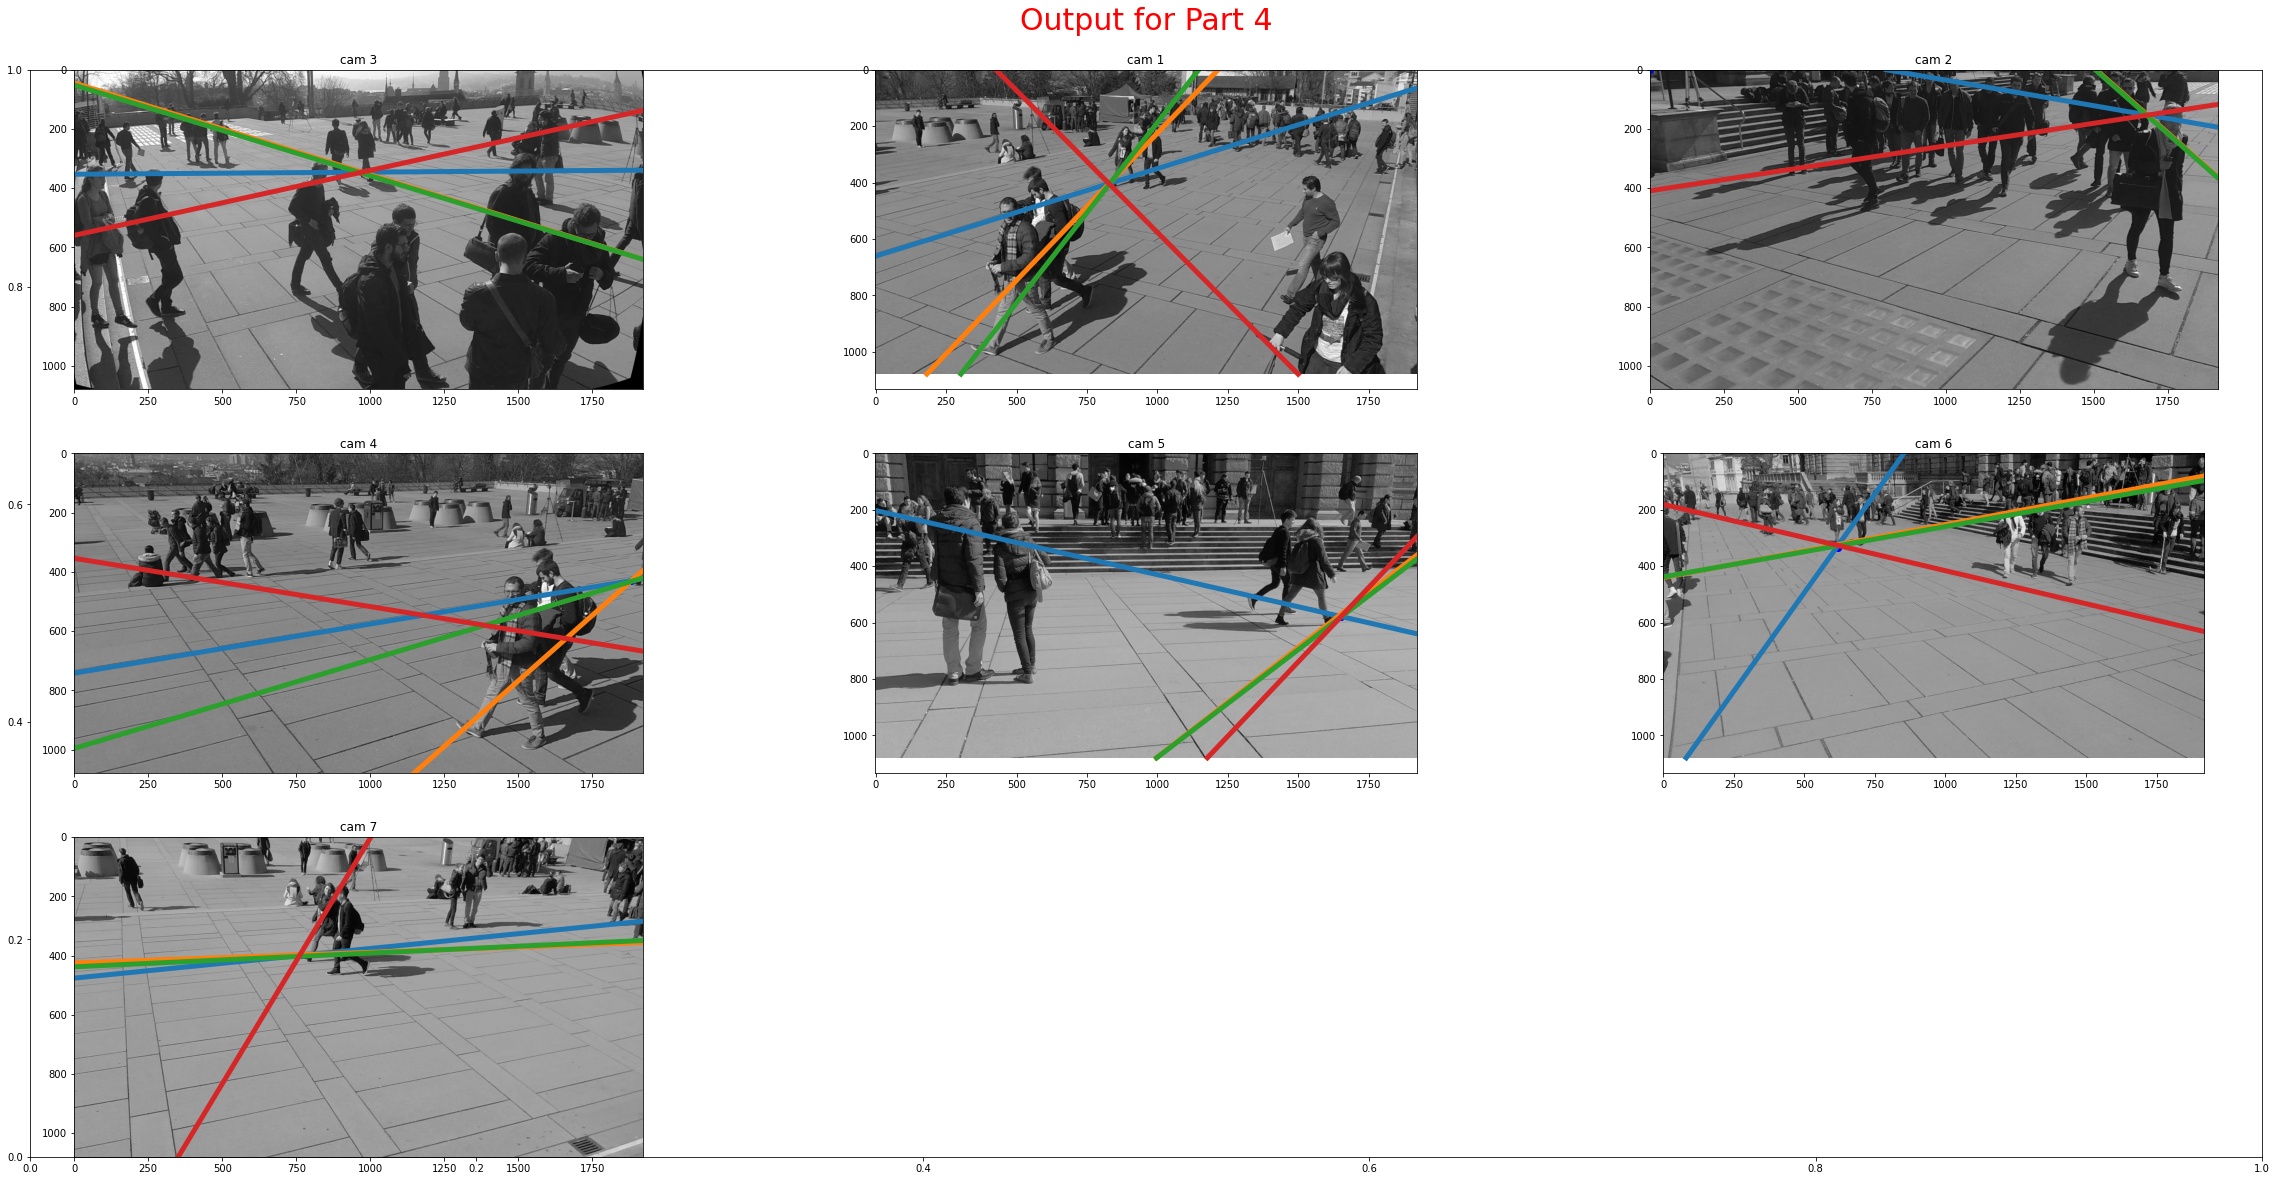

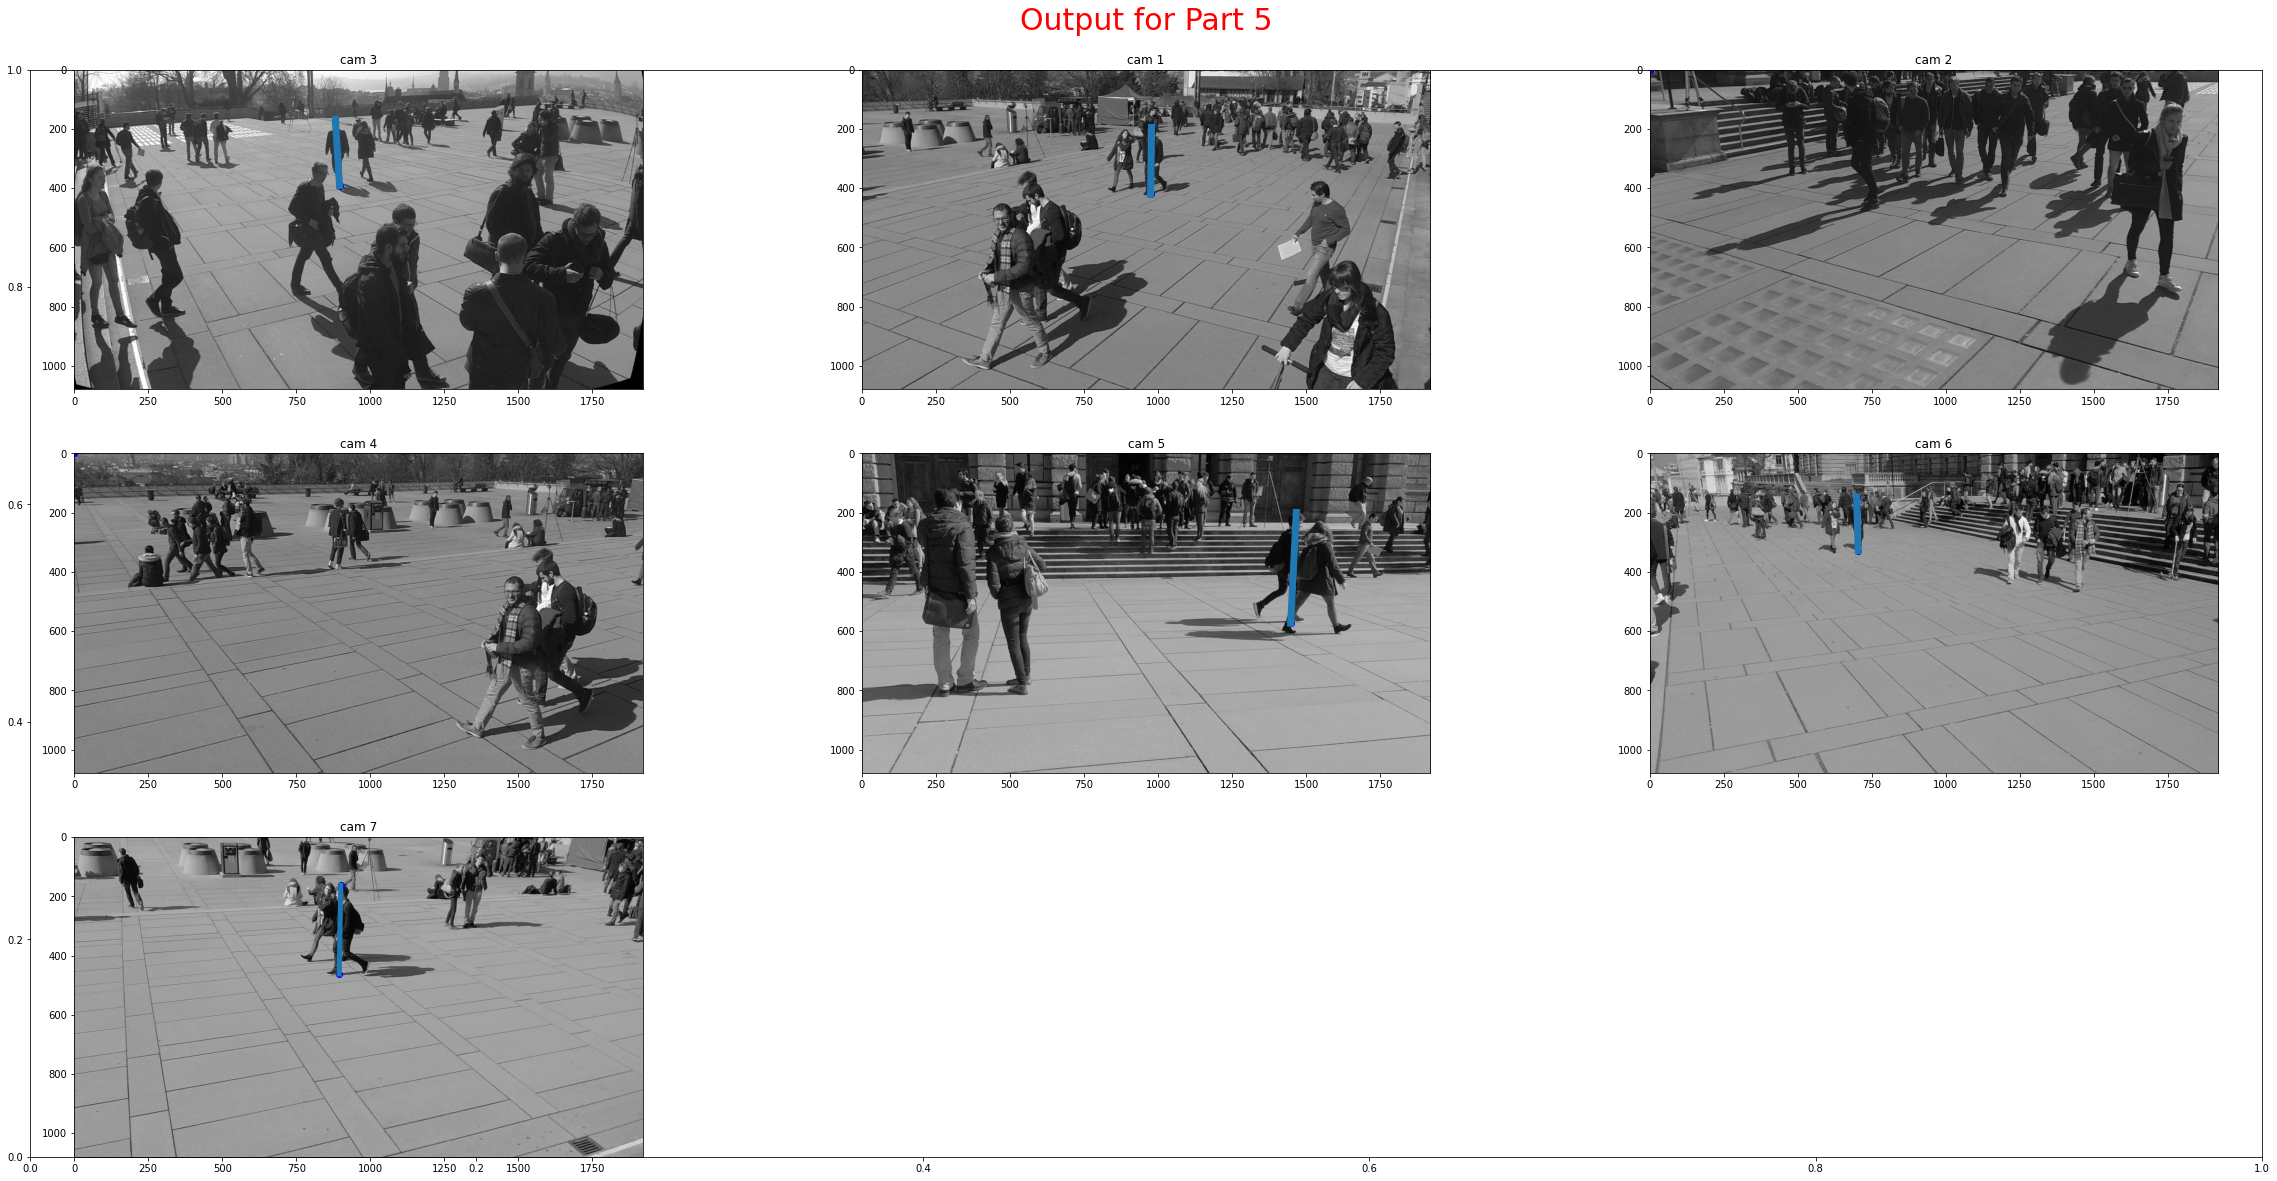

In [28]:
'''
-----------------------------------------------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------- Part 1 ----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------------------------------

'''

# Read calibration data of the WILDTRACK dataset. There are seven cameras arranged around an outdoor space.


calib_dir = '/content/drive/MyDrive/Colab Notebooks/Wildtrack/calibrations/'
extrinsic_calibration_files = ['extrinsic/extr_CVLab1.xml', 'extrinsic/extr_CVLab2.xml', 'extrinsic/extr_CVLab3.xml',
                               'extrinsic/extr_CVLab4.xml', 'extrinsic/extr_IDIAP1.xml', 'extrinsic/extr_IDIAP2.xml',
                               'extrinsic/extr_IDIAP3.xml']
intrinsic_calibration_files = ['intrinsic_zero/intr_CVLab1.xml', 'intrinsic_zero/intr_CVLab2.xml', 'intrinsic_zero/intr_CVLab3.xml',
                               'intrinsic_zero/intr_CVLab4.xml', 'intrinsic_zero/intr_IDIAP1.xml', 'intrinsic_zero/intr_IDIAP2.xml',
                               'intrinsic_zero/intr_IDIAP3.xml']
                        
''' Read in the images '''
Cam = ['C1', 'C2', 'C3', 'C4', 'C5','C6','C7']


R_list = [] # list of rotations, w.r.t individual cameras
T_list = [] # list of translations, w.r.t individual cameras
K_list = [] # list of intrinsic parameters for individual cameras
c_list = [] # list of camera locations w.r.t world coordinates


fig, ax = plt.subplots()
ax.set_aspect(1.0)
for i in range(7) :
    #read extrinsic parameters
    extr_file = calib_dir + extrinsic_calibration_files[i]
    xml_data = open(extr_file, 'r').read()  # Read data
    xmlDict = xmltodict.parse(xml_data)  # Parse XML
    rot_rodriges = np.fromstring(xmlDict['opencv_storage']['rvec'], sep=' ')

    R = Rotation.from_rotvec(rot_rodriges).as_matrix() # get the rotation 
    R_list.append(R) # add to list
    T = np.fromstring(xmlDict['opencv_storage']['tvec'], sep=' ')  # get the translation
    T_list.append(T) # add to list
    c_list.append(-np.transpose(R_list[i]) @ T_list[i][:,None])  # get the camera coordinates
    
    # plot the plane with camera location and origin
    ax.set_title('Camera placements')
    ax.plot(c_list[i][0], c_list[i][1], 'ro')
    ax.text(c_list[i][0]+10, c_list[i][1]+10, 'Camera {}'.format(i+1))
    
    # plot the arrow for view direction for each camera
    ax.quiver(c_list[i][0], c_list[i][1], -1000 * R[0,1], 1000* R[0, 0], units='inches', headwidth=5, pivot='tail', width=0.02, scale=4000)
    ax.plot(R[0, 1],R[0, 0], 'bo') 

    # read intrinsic parameters
    intr_file = calib_dir + intrinsic_calibration_files[i]
    xml_data = open(intr_file, 'r').read()  # Read data
    xmlDict = xmltodict.parse(xml_data)  # Parse XML
    K_mat = np.fromstring(xmlDict['opencv_storage']['camera_matrix']['data'], sep=' ').reshape(3,3)
    K_list.append(K_mat)
   
# Form P array of N_cameras by 3 by 4
N = len(R_list)
P_mat = np.zeros((N, 3, 4))
for j in range(N) :
    P_mat[j,:,:] = K_list[j] @ np.column_stack((R_list[j], T_list[j]))

# in this asssignment i have used frame 15 from all the cameras.

# read the images 
''' Read in the images '''
image_1 = io.imread('/content/drive/MyDrive/Colab Notebooks/Wildtrack/C3/00000015.png')
image_2 = io.imread('/content/drive/MyDrive/Colab Notebooks/Wildtrack/C1/00000015.png')
image_3 = io.imread('/content/drive/MyDrive/Colab Notebooks/Wildtrack/C2/00000015.png')
image_4 = io.imread('/content/drive/MyDrive/Colab Notebooks/Wildtrack/C4/00000015.png')
image_5 = io.imread('/content/drive/MyDrive/Colab Notebooks/Wildtrack/C5/00000015.png')
image_6 = io.imread('/content/drive/MyDrive/Colab Notebooks/Wildtrack/C6/00000015.png')
image_7 = io.imread('/content/drive/MyDrive/Colab Notebooks/Wildtrack/C7/00000015.png')


image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB) # change from scikit image to cv2 format
image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB)
image_3 = cv2.cvtColor(image_3, cv2.COLOR_BGR2RGB)
image_4 = cv2.cvtColor(image_4, cv2.COLOR_BGR2RGB)
image_5 = cv2.cvtColor(image_5, cv2.COLOR_BGR2RGB)
image_6 = cv2.cvtColor(image_6, cv2.COLOR_BGR2RGB)
image_7 = cv2.cvtColor(image_7, cv2.COLOR_BGR2RGB)

image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY) # change from color to gray
image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2GRAY)
image_3 = cv2.cvtColor(image_3, cv2.COLOR_BGR2GRAY)
image_4 = cv2.cvtColor(image_4, cv2.COLOR_BGR2GRAY)
image_5 = cv2.cvtColor(image_5, cv2.COLOR_BGR2GRAY)
image_6 = cv2.cvtColor(image_6, cv2.COLOR_BGR2GRAY)
image_7 = cv2.cvtColor(image_7, cv2.COLOR_BGR2GRAY)



# start plotting
fig = plt.figure(figsize=(40, 20))

plt.title(label="Output for Part 1\n", fontsize=30, color="Red")

# used quiver function to plot the arrow as we know that we can get the origin of the image from camera from instrinsic parameters
# i converted the intrinsic parameter to 2D and plot the arrow in each direction from that point

fig.add_subplot(3, 3, 1)
plt.imshow(image_1, 'gray')
plt.title('cam 3')
# plotting the arrow
#z-coordinate
plt.quiver(K_list[2][0]/K_list[2][2], K_list[2][1]/K_list[2][2], 3000 * R[1,1], -3000* R[1, -1], units='inches', headwidth=5, pivot='tail', width=0.02, color='b', scale=5000)
#y-coordinate
plt.quiver(K_list[2][0]/K_list[2][2], K_list[2][1]/K_list[2][2], 6000 * R[0,0], -6000* R[1, 1], units='inches', headwidth=5, pivot='tail', width=0.02, color='g', scale=5000)
#x-coordinate
plt.quiver(K_list[2][0]/K_list[2][2], K_list[2][1]/K_list[2][2], 5000 * R[0,0], -5000* R[1, 0], units='inches', headwidth=5, pivot='tail', width=0.02, color='r', scale=5000)

plt.legend(["Z", "Y", "X"])


fig.add_subplot(3, 3, 2)
plt.imshow(image_2, 'gray')
plt.title('cam 1')
#z-coordinate
plt.quiver(K_list[0][0]/K_list[0][2], K_list[0][1]/K_list[0][2], 3000 * R[1,1], -3000* R[1, -1], units='inches', headwidth=5, pivot='tail', width=0.02, color='b', scale=5000)
#y-coordinate
plt.quiver(K_list[0][0]/K_list[0][2], K_list[0][1]/K_list[0][2], 6000 * R[0,0], -6000* R[1, 1], units='inches', headwidth=5, pivot='tail', width=0.02, color='g', scale=5000)
#x-coordinate
plt.quiver(K_list[0][0]/K_list[0][2], K_list[0][1]/K_list[0][2], 5000 * R[0,0], -5000* R[1, 0], units='inches', headwidth=5, pivot='tail', width=0.02, color='r', scale=5000)

plt.legend(["Z", "Y", "X"])


fig.add_subplot(3, 3, 3)
plt.imshow(image_3, 'gray')
plt.title('cam 2')

#z-coordinate
plt.quiver(K_list[1][0]/K_list[1][2], K_list[1][1]/K_list[1][2], 3000 * R[1,1], -3000* R[1, -1], units='inches', headwidth=5, pivot='tail', width=0.02, color='b', scale=5000)
#y-coordinate
plt.quiver(K_list[1][0]/K_list[1][2], K_list[1][1]/K_list[1][2], 6000 * R[0,0], -6000* R[1, 1], units='inches', headwidth=5, pivot='tail', width=0.02, color='g', scale=5000)
#x-coordinate
plt.quiver(K_list[1][0]/K_list[1][2], K_list[1][1]/K_list[1][2], 5000 * R[0,0], -5000* R[1, 0], units='inches', headwidth=5, pivot='tail', width=0.02, color='r', scale=5000)

plt.legend(["Z", "Y", "X"])


fig.add_subplot(3, 3, 4)
plt.imshow(image_4, 'gray')
plt.title('cam 4')

#z-coordinate
plt.quiver(K_list[3][0]/K_list[3][2], K_list[3][1]/K_list[3][2], 3000 * R[1,1], -3000* R[1, -1], units='inches', headwidth=5, pivot='tail', width=0.02, color='b', scale=5000)
#y-coordinate
plt.quiver(K_list[3][0]/K_list[3][2], K_list[3][1]/K_list[3][2], 6000 * R[0,0], -6000* R[1, 1], units='inches', headwidth=5, pivot='tail', width=0.02, color='g', scale=5000)
#x-coordinate
plt.quiver(K_list[3][0]/K_list[3][2], K_list[3][1]/K_list[3][2], 5000 * R[0,0], -5000* R[1, 0], units='inches', headwidth=5, pivot='tail', width=0.02, color='r', scale=5000)

plt.legend(["Z", "Y", "X"])

fig.add_subplot(3, 3, 5)
plt.imshow(image_5, 'gray')

plt.title('cam 5')

#z-coordinate
plt.quiver(K_list[4][0]/K_list[4][2], K_list[4][1]/K_list[4][2], 3000 * R[1,1], -3000* R[1, -1], units='inches', headwidth=5, pivot='tail', width=0.02, color='b', scale=5000)
#y-coordinate
plt.quiver(K_list[4][0]/K_list[4][2], K_list[4][1]/K_list[4][2], 6000 * R[0,0], -6000* R[1, 1], units='inches', headwidth=5, pivot='tail', width=0.02, color='g', scale=5000)
#x-coordinate
plt.quiver(K_list[4][0]/K_list[4][2], K_list[4][1]/K_list[4][2], 5000 * R[0,0], -5000* R[1, 0], units='inches', headwidth=5, pivot='tail', width=0.02, color='r', scale=5000)

plt.legend(["Z", "Y", "X"])

fig.add_subplot(3, 3, 6)
plt.imshow(image_6, 'gray')

plt.title('cam 6')

#z-coordinate
plt.quiver(K_list[5][0]/K_list[5][2], K_list[5][1]/K_list[5][2], 3000 * R[1,1], -3000* R[1, -1], units='inches', headwidth=5, pivot='tail', width=0.02, color='b', scale=5000)
#y-coordinate
plt.quiver(K_list[5][0]/K_list[5][2], K_list[5][1]/K_list[5][2], 6000 * R[0,0], -6000* R[1, 1], units='inches', headwidth=5, pivot='tail', width=0.02, color='g', scale=5000)
#x-coordinate
plt.quiver(K_list[5][0]/K_list[5][2], K_list[5][1]/K_list[5][2], 5000 * R[0,0], -5000* R[1, 0], units='inches', headwidth=5, pivot='tail', width=0.02, color='r', scale=5000)

plt.legend(["Z", "Y", "X"])

fig.add_subplot(3, 3, 7)
plt.imshow(image_7, 'gray')
plt.title('cam 7')

#z-coordinate
plt.quiver(K_list[6][0]/K_list[6][2], K_list[6][1]/K_list[6][2], 3000 * R[1,1], -3000* R[1, -1], units='inches', headwidth=5, pivot='tail', width=0.02, color='b', scale=5000)
#y-coordinate
plt.quiver(K_list[6][0]/K_list[6][2], K_list[6][1]/K_list[6][2], 6000 * R[0,0], -6000* R[1, 1], units='inches', headwidth=5, pivot='tail', width=0.02, color='g', scale=5000)
#x-coordinate
plt.quiver(K_list[6][0]/K_list[6][2], K_list[6][1]/K_list[6][2], 5000 * R[0,0], -5000* R[1, 0], units='inches', headwidth=5, pivot='tail', width=0.02, color='r', scale=5000)

plt.legend(["Z", "Y", "X"])

'''
-----------------------------------------------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------- Part 2 ----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------------------------------

'''


E34, F34, R34, T34 = compute_essential_fundamental_matrices (R_list[2], T_list[2], K_list[2], R_list[3], T_list[3], K_list[3])
#print('Essential matrix_34:\n', E34)
#print('Fundamental matrix_34:\n', F34)
K34_left = K_list[2]
K34_right = K_list[3]

E33, F33, R33, T33 = compute_essential_fundamental_matrices (R_list[2], T_list[2], K_list[2], R_list[2], T_list[2], K_list[2])
#print('Essential matrix_33:\n', E33)
#print('Fundamental matrix_33:\n', F33)
K33_left = K_list[2]
K33_right = K_list[2]

E31, F31, R31, T31 = compute_essential_fundamental_matrices (R_list[2], T_list[2], K_list[2], R_list[0], T_list[0], K_list[0])
#print('Essential matrix_31:\n', E31)
#print('Fundamental matrix_31:\n', F31)
K31_left = K_list[2]
K31_right = K_list[0]

E32, F32, R32, T32 = compute_essential_fundamental_matrices (R_list[2], T_list[2], K_list[2], R_list[1], T_list[1], K_list[1])
#print('Essential matrix_32:\n', E32)
#print('Fundamental matrix_32:\n', F32)
K32_left = K_list[2]
K32_right = K_list[1]


E35, F35, R35, T35 = compute_essential_fundamental_matrices (R_list[2], T_list[2], K_list[2], R_list[4], T_list[4], K_list[4])
#print('Essential matrix_35:\n', E35)
#print('Fundamental matrix_32:\n', F35)
K35_left = K_list[2]
K35_right = K_list[4]

E36, F36, R36, T36 = compute_essential_fundamental_matrices (R_list[2], T_list[2], K_list[2], R_list[5], T_list[5], K_list[5])
#print('Essential matrix_36:\n', E36)
#print('Fundamental matrix_36:\n', F36)
K35_left = K_list[2]
K35_right = K_list[5]

E37, F37, R37, T37 = compute_essential_fundamental_matrices (R_list[2], T_list[2], K_list[2], R_list[6], T_list[6], K_list[6])
#print('Essential matrix_37:\n', E37)
#print('Fundamental matrix_37:\n', F37)
K35_left = K_list[2]
K35_right = K_list[6]

#----------------------------------Display-------------------------------------------------------------------------------------

# Picked a corresponding point across the 7 cameras corresponding to the shoe-tip of a person 
shoe_tip = np.array([[831, 401], [0, 0], [967, 346], [1882, 432], [1650, 580], [620, 335], [765, 398]])
p1 = shoe_tip[2]; p2 = shoe_tip[0]; p3 = shoe_tip[1]; p4 = shoe_tip[3]; p5 = shoe_tip[4]; p6 = shoe_tip[5]; p7 = shoe_tip[6]


fig = plt.figure(figsize=(40, 20))


plt.title(label="Output for Part 2\n", fontsize=30, color="Red")

fig.add_subplot(3, 3, 1)
plt.imshow(image_1, 'gray')
plt.plot(p1[0], p1[1], 'ro')
plt.title('cam 3')
#x_1, y_1, x_2, y_2 = epipolar_lines (F33, p1[:,None], image_1.shape, image_1.shape)
#plt.plot(x_1, y_1, linewidth=8)
#plt.plot(x_2, y_2, linewidth=5);

fig.add_subplot(3, 3, 2)
plt.imshow(image_2, 'gray')
plt.plot(p2[0], p2[1], 'bo')
plt.title('cam 1')
x_1, y_1, x_2, y_2 = epipolar_lines (F31, p1[:,None], image_1.shape, image_2.shape)
#plt.plot(x_1, y_1, linewidth=8)
plt.plot(x_2, y_2, linewidth=5);


fig.add_subplot(3, 3, 3)
plt.imshow(image_3, 'gray')
plt.plot(p3[0], p3[1], 'bo')
plt.title('cam 2')
x_1, y_1, x_2, y_2 = epipolar_lines (F32, p1[:,None], image_1.shape, image_3.shape)
#plt.plot(x_1, y_1, linewidth=8)
plt.plot(x_2, y_2, linewidth=5);

fig.add_subplot(3, 3, 4)
plt.imshow(image_4, 'gray')
plt.plot(p4[0], p4[1], 'bo')
plt.title('cam 4')
x_1, y_1, x_2, y_2 = epipolar_lines (F34, p1[:,None], image_1.shape, image_4.shape)
#plt.plot(x_1, y_1, linewidth=8)
plt.plot(x_2, y_2, linewidth=5);

fig.add_subplot(3, 3, 5)
plt.imshow(image_5, 'gray')
plt.plot(p5[0], p5[1], 'bo')
plt.title('cam 5')
x_1, y_1, x_2, y_2 = epipolar_lines (F35, p1[:,None], image_1.shape, image_5.shape)
#plt.plot(x_1, y_1, linewidth=8)
plt.plot(x_2, y_2, linewidth=5);

fig.add_subplot(3, 3, 6)
plt.imshow(image_6, 'gray')
plt.plot(p6[0], p6[1], 'bo')
plt.title('cam 6')
x_1, y_1, x_2, y_2 = epipolar_lines (F36, p1[:,None], image_1.shape, image_6.shape)
#plt.plot(x_1, y_1, linewidth=8)
plt.plot(x_2, y_2, linewidth=5);

fig.add_subplot(3, 3, 7)
plt.imshow(image_7, 'gray')
plt.plot(p7[0], p7[1], 'bo')
plt.title('cam 7')
x_1, y_1, x_2, y_2 = epipolar_lines (F37, p1[:,None], image_1.shape, image_7.shape)
#plt.plot(x_1, y_1, linewidth=8)
plt.plot(x_2, y_2, linewidth=5);


'''
-----------------------------------------------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------- Part 3 ----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------------------------------
'''


E11, F11, R11, T11 = compute_essential_fundamental_matrices (R_list[0], T_list[0], K_list[0], R_list[0], T_list[0], K_list[0])
#print('Essential matrix_11:\n', E11)
#print('Fundamental matrix_11:\n', F11)
K11_left = K_list[0]
K11_right = K_list[0]


E12, F12, R12, T12 = compute_essential_fundamental_matrices (R_list[0], T_list[0], K_list[0], R_list[1], T_list[1], K_list[1])
#print('Essential matrix_12:\n', E12)
#print('Fundamental matrix_12:\n', F12)
K12_left = K_list[0]
K12_right = K_list[1]

E13, F13, R13, T13 = compute_essential_fundamental_matrices (R_list[0], T_list[0], K_list[0], R_list[2], T_list[2], K_list[2])
#print('Essential matrix_13:\n', E13)
#print('Fundamental matrix_13:\n', F13)
K13_left = K_list[0]
K13_right = K_list[2]

E14, F14, R14, T14 = compute_essential_fundamental_matrices (R_list[0], T_list[0], K_list[0], R_list[3], T_list[3], K_list[3])
#print('Essential matrix_14:\n', E14)
#print('Fundamental matrix_14:\n', F14)
K14_left = K_list[0]
K14_right = K_list[3]

E15, F15, R15, T15 = compute_essential_fundamental_matrices (R_list[0], T_list[0], K_list[0], R_list[4], T_list[4], K_list[4])
#print('Essential matrix_15:\n', E15)
#print('Fundamental matrix_15:\n', F15)
K15_left = K_list[0]
K15_right = K_list[4]

E16, F16, R16, T16 = compute_essential_fundamental_matrices (R_list[0], T_list[0], K_list[0], R_list[5], T_list[5], K_list[5])
#print('Essential matrix_16:\n', E16)
#print('Fundamental matrix_16:\n', F16)
K16_left = K_list[0]
K16_right = K_list[5]

E17, F17, R17, T17 = compute_essential_fundamental_matrices (R_list[0], T_list[0], K_list[0], R_list[6], T_list[6], K_list[6])
#print('Essential matrix_17:\n', E17)
#print('Fundamental matrix_17:\n', F17)
K17_left = K_list[0]
K17_right = K_list[6]

#-----------------------------------------------------------------------------------------------------------------------------------------

#----------------------------------Display------------------------------------------------------------------------------------------------

# Picked a corresponding point across the 7 cameras corresponding to the shoe-tip of a person 
shoe_tip = np.array([[831, 401], [0, 0], [967, 346], [1882, 432], [1650, 580], [620, 335], [765, 398]])
p1 = shoe_tip[2]; p2 = shoe_tip[0]; p3 = shoe_tip[1]; p4 = shoe_tip[3]; p5 = shoe_tip[4]; p6 = shoe_tip[5]; p7 = shoe_tip[6]



fig = plt.figure(figsize=(40, 20))

plt.title(label="Output for Part 3\n", fontsize=30, color="Red")

fig.add_subplot(3, 3, 1)
plt.imshow(image_1, 'gray')
plt.plot(p1[0], p1[1], 'ro')
plt.title('cam 3')
x_1, y_1, x_2, y_2 = epipolar_lines (F33, p1[:,None], image_1.shape, image_1.shape)
#plt.plot(x_1, y_1, linewidth=8)
plt.plot(x_2, y_2, linewidth=5);

x_1, y_1, x_2, y_2 = epipolar_lines (F13, p2[:,None], image_2.shape, image_1.shape)
#plt.plot(x_1, y_1, linewidth=8)
plt.plot(x_2, y_2, linewidth=5);

fig.add_subplot(3, 3, 2)
plt.imshow(image_2, 'gray')
plt.plot(p2[0], p2[1], 'bo')
plt.title('cam 1')
x_1, y_1, x_2, y_2 = epipolar_lines (F31, p1[:,None], image_1.shape, image_2.shape)
#plt.plot(x_1, y_1, linewidth=8)
plt.plot(x_2, y_2, linewidth=5);

x_1, y_1, x_2, y_2 = epipolar_lines (F11, p2[:,None], image_2.shape, image_2.shape)
#plt.plot(x_1, y_1, linewidth=8)
plt.plot(x_2, y_2, linewidth=5);

fig.add_subplot(3, 3, 3)
plt.imshow(image_3, 'gray')
plt.plot(p3[0], p3[1], 'bo')
plt.title('cam 2')
x_1, y_1, x_2, y_2 = epipolar_lines (F32, p1[:,None], image_1.shape, image_3.shape)
#plt.plot(x_1, y_1, linewidth=8)
plt.plot(x_2, y_2, linewidth=5);

x_1, y_1, x_2, y_2 = epipolar_lines (F12, p2[:,None], image_2.shape, image_3.shape)
#plt.plot(x_1, y_1, linewidth=8)
plt.plot(x_2, y_2, linewidth=5);

fig.add_subplot(3, 3, 4)
plt.imshow(image_4, 'gray')
plt.plot(p4[0], p4[1], 'bo')
plt.title('cam 4')
x_1, y_1, x_2, y_2 = epipolar_lines (F34, p1[:,None], image_1.shape, image_4.shape)
#plt.plot(x_1, y_1, linewidth=8)
plt.plot(x_2, y_2, linewidth=5);

x_1, y_1, x_2, y_2 = epipolar_lines (F14, p2[:,None], image_2.shape, image_4.shape)
#plt.plot(x_1, y_1, linewidth=8)
plt.plot(x_2, y_2, linewidth=5);


fig.add_subplot(3, 3, 5)
plt.imshow(image_5, 'gray')
plt.plot(p5[0], p5[1], 'bo')
plt.title('cam 5')
x_1, y_1, x_2, y_2 = epipolar_lines (F35, p1[:,None], image_1.shape, image_5.shape)
#plt.plot(x_1, y_1, linewidth=8)
plt.plot(x_2, y_2, linewidth=5);

x_1, y_1, x_2, y_2 = epipolar_lines (F15, p2[:,None], image_2.shape, image_5.shape)
#plt.plot(x_1, y_1, linewidth=8)
plt.plot(x_2, y_2, linewidth=5);


fig.add_subplot(3, 3, 6)
plt.imshow(image_6, 'gray')
plt.plot(p6[0], p6[1], 'bo')
plt.title('cam 6')
x_1, y_1, x_2, y_2 = epipolar_lines (F36, p1[:,None], image_1.shape, image_6.shape)
#plt.plot(x_1, y_1, linewidth=8)
plt.plot(x_2, y_2, linewidth=5);

x_1, y_1, x_2, y_2 = epipolar_lines (F16, p2[:,None], image_2.shape, image_6.shape)
#plt.plot(x_1, y_1, linewidth=8)
plt.plot(x_2, y_2, linewidth=5);


fig.add_subplot(3, 3, 7)
plt.imshow(image_7, 'gray')
plt.plot(p7[0], p7[1], 'bo')
plt.title('cam 7')
x_1, y_1, x_2, y_2 = epipolar_lines (F37, p1[:,None], image_1.shape, image_7.shape)
#plt.plot(x_1, y_1, linewidth=8)
plt.plot(x_2, y_2, linewidth=5);

x_1, y_1, x_2, y_2 = epipolar_lines (F17, p2[:,None], image_2.shape, image_7.shape)
#plt.plot(x_1, y_1, linewidth=8)
plt.plot(x_2, y_2, linewidth=5);





'''
-----------------------------------------------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------- Part 4 ----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------------------------------

'''



E41, F41, R41, T41 = compute_essential_fundamental_matrices (R_list[3], T_list[3], K_list[3], R_list[0], T_list[0], K_list[0])
#print('Essential matrix_41:\n', E41)
#print('Fundamental matrix_41:\n', F41)
K41_left = K_list[3]
K41_right = K_list[0]

E42, F42, R42, T42 = compute_essential_fundamental_matrices (R_list[3], T_list[3], K_list[3], R_list[1], T_list[1], K_list[1])
#print('Essential matrix_42:\n', E42)
#print('Fundamental matrix_42:\n', F42)
K42_left = K_list[3]
K42_right = K_list[1]

E43, F43, R43, T43 = compute_essential_fundamental_matrices (R_list[3], T_list[3], K_list[3], R_list[2], T_list[2], K_list[2])
#print('Essential matrix_43:\n', E43)
#print('Fundamental matrix_43:\n', F43)
K43_left = K_list[3]
K43_right = K_list[2]

E44, F44, R44, T44 = compute_essential_fundamental_matrices (R_list[3], T_list[3], K_list[3], R_list[3], T_list[3], K_list[3])
#print('Essential matrix_44:\n', E44)
#print('Fundamental matrix_44:\n', F44)
K44_left = K_list[3]
K44_right = K_list[3]

E45, F45, R45, T45 = compute_essential_fundamental_matrices (R_list[3], T_list[3], K_list[3], R_list[4], T_list[4], K_list[4])
#print('Essential matrix_45:\n', E45)
#print('Fundamental matrix_45:\n', F45)
K45_left = K_list[3]
K45_right = K_list[4]

E46, F46, R46, T46 = compute_essential_fundamental_matrices (R_list[3], T_list[3], K_list[3], R_list[5], T_list[5], K_list[5])
#print('Essential matrix_46:\n', E46)
#print('Fundamental matrix_46:\n', F46)
K46_left = K_list[3]
K46_right = K_list[5]

E47, F47, R47, T47 = compute_essential_fundamental_matrices (R_list[3], T_list[3], K_list[3], R_list[6], T_list[6], K_list[6])
#print('Essential matrix_47:\n', E47)
#print('Fundamental matrix_47:\n', F47)
K47_left = K_list[3]
K47_right = K_list[6]
#-----------------------------------------------------------------------------------------------------------------------------------------

#-------------------------------------------------- Cam 5 --------------------------------------------------------------------------------

E51, F51, R51, T51 = compute_essential_fundamental_matrices (R_list[4], T_list[4], K_list[4], R_list[0], T_list[0], K_list[0])
#print('Essential matrix_51:\n', E51)
#print('Fundamental matrix_51:\n', F51)
K51_left = K_list[4]
K51_right = K_list[0]

E52, F52, R52, T52 = compute_essential_fundamental_matrices (R_list[4], T_list[4], K_list[4], R_list[1], T_list[1], K_list[1])
#print('Essential matrix_52:\n', E52)
#print('Fundamental matrix_52:\n', F52)
K52_left = K_list[4]
K52_right = K_list[1]

E53, F53, R53, T53 = compute_essential_fundamental_matrices (R_list[4], T_list[4], K_list[4], R_list[2], T_list[2], K_list[2])
#print('Essential matrix_53:\n', E53)
#print('Fundamental matrix_53:\n', F53)
K53_left = K_list[4]
K53_right = K_list[2]

E54, F54, R54, T54 = compute_essential_fundamental_matrices (R_list[4], T_list[4], K_list[4], R_list[4], T_list[3], K_list[3])
#print('Essential matrix_54:\n', E54)
#print('Fundamental matrix_54:\n', F54)
K54_left = K_list[4]
K54_right = K_list[3]

E55, F55, R55, T55 = compute_essential_fundamental_matrices (R_list[4], T_list[4], K_list[4], R_list[4], T_list[4], K_list[4])
#print('Essential matrix_55:\n', E55)
#print('Fundamental matrix_55:\n', F55)
K55_left = K_list[4]
K55_right = K_list[4]

E56, F56, R56, T56 = compute_essential_fundamental_matrices (R_list[4], T_list[4], K_list[4], R_list[5], T_list[5], K_list[5])
#print('Essential matrix_56:\n', E56)
#print('Fundamental matrix_56:\n', F56)
K56_left = K_list[4]
K56_right = K_list[5]

E57, F57, R57, T57 = compute_essential_fundamental_matrices (R_list[4], T_list[4], K_list[4], R_list[6], T_list[6], K_list[6])
#print('Essential matrix_57:\n', E57)
#print('Fundamental matrix_57:\n', F57)
K57_left = K_list[4]
K57_right = K_list[6]

#----------------------------------------------------------------------------------------------------------------------------------------


#----------------------------------Display-------------------------------------------------------

# Picked a corresponding point across the 7 cameras corresponding to the shoe-tip of a person 
shoe_tip = np.array([[831, 401], [0, 0], [967, 346], [1882, 432], [1650, 580], [620, 335], [765, 398]])
p1 = shoe_tip[2]; p2 = shoe_tip[0]; p3 = shoe_tip[1]; p4 = shoe_tip[3]; p5 = shoe_tip[4]; p6 = shoe_tip[5]; p7 = shoe_tip[6]



fig = plt.figure(figsize=(40, 20))
plt.title(label="Output for Part 4\n", fontsize=30, color="Red")

fig.add_subplot(3, 3, 1)
plt.imshow(image_1, 'gray')
plt.plot(p1[0], p1[1], 'ro')
plt.title('cam 3')
x_1, y_1, x_2, y_2 = epipolar_lines (F33, p1[:,None], image_1.shape, image_1.shape)
#plt.plot(x_1, y_1, linewidth=8)
plt.plot(x_2, y_2, linewidth=5);

x_1, y_1, x_2, y_2 = epipolar_lines (F13, p2[:,None], image_2.shape, image_1.shape)
#plt.plot(x_1, y_1, linewidth=8)
plt.plot(x_2, y_2, linewidth=5);

x_1, y_1, x_2, y_2 = epipolar_lines (F43, p4[:,None], image_4.shape, image_1.shape)
#plt.plot(x_1, y_1, linewidth=8)
plt.plot(x_2, y_2, linewidth=5);

x_1, y_1, x_2, y_2 = epipolar_lines (F53, p5[:,None], image_5.shape, image_1.shape)
#plt.plot(x_1, y_1, linewidth=8)
plt.plot(x_2, y_2, linewidth=5);

fig.add_subplot(3, 3, 2)
plt.imshow(image_2, 'gray')
plt.plot(p2[0], p2[1], 'bo')
plt.title('cam 1')
x_1, y_1, x_2, y_2 = epipolar_lines (F31, p1[:,None], image_1.shape, image_2.shape)
#plt.plot(x_1, y_1, linewidth=8)
plt.plot(x_2, y_2, linewidth=5);

x_1, y_1, x_2, y_2 = epipolar_lines (F11, p2[:,None], image_2.shape, image_2.shape)
#plt.plot(x_1, y_1, linewidth=8)
plt.plot(x_2, y_2, linewidth=5);

x_1, y_1, x_2, y_2 = epipolar_lines (F41, p4[:,None], image_4.shape, image_2.shape)
#plt.plot(x_1, y_1, linewidth=8)
plt.plot(x_2, y_2, linewidth=5);

x_1, y_1, x_2, y_2 = epipolar_lines (F51, p5[:,None], image_5.shape, image_2.shape)
#plt.plot(x_1, y_1, linewidth=8)
plt.plot(x_2, y_2, linewidth=5);

fig.add_subplot(3, 3, 3)
plt.imshow(image_3, 'gray')
plt.plot(p3[0], p3[1], 'bo')
plt.title('cam 2')
x_1, y_1, x_2, y_2 = epipolar_lines (F32, p1[:,None], image_1.shape, image_3.shape)
#plt.plot(x_1, y_1, linewidth=8)
plt.plot(x_2, y_2, linewidth=5);

x_1, y_1, x_2, y_2 = epipolar_lines (F12, p2[:,None], image_2.shape, image_3.shape)
#plt.plot(x_1, y_1, linewidth=8)
plt.plot(x_2, y_2, linewidth=5);

x_1, y_1, x_2, y_2 = epipolar_lines (F42, p4[:,None], image_4.shape, image_3.shape)
#plt.plot(x_1, y_1, linewidth=8)
plt.plot(x_2, y_2, linewidth=5);

x_1, y_1, x_2, y_2 = epipolar_lines (F52, p5[:,None], image_5.shape, image_3.shape)
#plt.plot(x_1, y_1, linewidth=8)
plt.plot(x_2, y_2, linewidth=5);

fig.add_subplot(3, 3, 4)
plt.imshow(image_4, 'gray')
plt.plot(p4[0], p4[1], 'bo')
plt.title('cam 4')
x_1, y_1, x_2, y_2 = epipolar_lines (F34, p1[:,None], image_1.shape, image_4.shape)
#plt.plot(x_1, y_1, linewidth=8)
plt.plot(x_2, y_2, linewidth=5);

x_1, y_1, x_2, y_2 = epipolar_lines (F14, p2[:,None], image_2.shape, image_4.shape)
#plt.plot(x_1, y_1, linewidth=8)
plt.plot(x_2, y_2, linewidth=5);

x_1, y_1, x_2, y_2 = epipolar_lines (F44, p4[:,None], image_4.shape, image_4.shape)
#plt.plot(x_1, y_1, linewidth=8)
plt.plot(x_2, y_2, linewidth=5);

x_1, y_1, x_2, y_2 = epipolar_lines (F54, p5[:,None], image_5.shape, image_4.shape)
#plt.plot(x_1, y_1, linewidth=8)
plt.plot(x_2, y_2, linewidth=5);


fig.add_subplot(3, 3, 5)
plt.imshow(image_5, 'gray')
plt.plot(p5[0], p5[1], 'bo')
plt.title('cam 5')
x_1, y_1, x_2, y_2 = epipolar_lines (F35, p1[:,None], image_1.shape, image_5.shape)
#plt.plot(x_1, y_1, linewidth=8)
plt.plot(x_2, y_2, linewidth=5);

x_1, y_1, x_2, y_2 = epipolar_lines (F15, p2[:,None], image_2.shape, image_5.shape)
#plt.plot(x_1, y_1, linewidth=8)
plt.plot(x_2, y_2, linewidth=5);

x_1, y_1, x_2, y_2 = epipolar_lines (F45, p4[:,None], image_4.shape, image_5.shape)
#plt.plot(x_1, y_1, linewidth=8)
plt.plot(x_2, y_2, linewidth=5);

x_1, y_1, x_2, y_2 = epipolar_lines (F55, p5[:,None], image_5.shape, image_5.shape)
#plt.plot(x_1, y_1, linewidth=8)
plt.plot(x_2, y_2, linewidth=5);

fig.add_subplot(3, 3, 6)
plt.imshow(image_6, 'gray')
plt.plot(p6[0], p6[1], 'bo')
plt.title('cam 6')
x_1, y_1, x_2, y_2 = epipolar_lines (F36, p1[:,None], image_1.shape, image_6.shape)
#plt.plot(x_1, y_1, linewidth=8)
plt.plot(x_2, y_2, linewidth=5);

x_1, y_1, x_2, y_2 = epipolar_lines (F16, p2[:,None], image_2.shape, image_6.shape)
#plt.plot(x_1, y_1, linewidth=8)
plt.plot(x_2, y_2, linewidth=5);

x_1, y_1, x_2, y_2 = epipolar_lines (F46, p4[:,None], image_4.shape, image_6.shape)
#plt.plot(x_1, y_1, linewidth=8)
plt.plot(x_2, y_2, linewidth=5);

x_1, y_1, x_2, y_2 = epipolar_lines (F56, p5[:,None], image_5.shape, image_6.shape)
#plt.plot(x_1, y_1, linewidth=8)
plt.plot(x_2, y_2, linewidth=5);

fig.add_subplot(3, 3, 7)
plt.imshow(image_7, 'gray')
plt.plot(p7[0], p7[1], 'bo')
plt.title('cam 7')
x_1, y_1, x_2, y_2 = epipolar_lines (F37, p1[:,None], image_1.shape, image_7.shape)
#plt.plot(x_1, y_1, linewidth=8)
plt.plot(x_2, y_2, linewidth=5);

x_1, y_1, x_2, y_2 = epipolar_lines (F17, p2[:,None], image_2.shape, image_7.shape)
#plt.plot(x_1, y_1, linewidth=8)
plt.plot(x_2, y_2, linewidth=5);

x_1, y_1, x_2, y_2 = epipolar_lines (F47, p4[:,None], image_4.shape, image_7.shape)
#plt.plot(x_1, y_1, linewidth=8)
plt.plot(x_2, y_2, linewidth=5);

x_1, y_1, x_2, y_2 = epipolar_lines (F57, p5[:,None], image_5.shape, image_7.shape)
#plt.plot(x_1, y_1, linewidth=8)
plt.plot(x_2, y_2, linewidth=5);





"""
-----------------------------------------------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------- Part 5 ----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------------------------------

"""


head_tip = np.array([[978, 195], [0, 0], [882, 167], [0, 0], [1467, 199], [699, 147], [900, 163]])
bottom_tip = np.array([[975, 421], [0, 0], [896, 391], [0, 0], [1448, 573], [704, 328], [895, 462]])


images = []
P = []


# Estimate 3D points using selected cameras
selected_list = [0,2,4,5,6]
K_list_selected = [K_list[i] for i in selected_list]
R_list_selected = [R_list[i] for i in selected_list]
T_list_selected = [T_list[i] for i in selected_list]

_, head_tip_3D = estimate_3D_pt_2D_residual_Gauss_Newton (np.transpose(head_tip)[:,selected_list], P_mat[selected_list,:,:])
_, bottom_tip_3D = estimate_3D_pt_2D_residual_Gauss_Newton (np.transpose(bottom_tip)[:,selected_list], P_mat[selected_list,:,:])


height = np.linalg.norm(head_tip_3D - bottom_tip_3D)

print("--------------------------------------------------------------------------------")
print("--------------------------------------------------------------------------------")
print('The height of the person height: ', height)
print("--------------------------------------------------------------------------------")
print("--------------------------------------------------------------------------------")

head_point1 = head_tip[0];head_point2 = head_tip[1];head_point3 = head_tip[2];head_point4 = head_tip[3];head_point5 = head_tip[4];head_point6 = head_tip[5];head_point7 = head_tip[6];
leg_point1 = bottom_tip[0];leg_point2 = bottom_tip[1];leg_point3 = bottom_tip[2];leg_point4 = bottom_tip[3];leg_point5 = bottom_tip[4];leg_point6 = bottom_tip[5];leg_point7 = bottom_tip[6];


fig = plt.figure(figsize=(40, 20))
plt.title(label="Output for Part 5\n", fontsize=30, color="Red")


fig.add_subplot(3, 3, 1)

plt.imshow(image_1, 'gray')
plt.plot(head_point3[0], head_point3[1], 'bo')
plt.plot(leg_point3[0], leg_point3[1], 'bo')

x3 = [head_point3[0], leg_point3[0]]
y3 = [head_point3[1], leg_point3[1]]
plt.plot(x3, y3, linewidth=7)
plt.title('cam 3')


fig.add_subplot(3, 3, 2)
plt.imshow(image_2, 'gray')
plt.plot(head_point1[0], head_point1[1], 'bo')
plt.plot(leg_point1[0], leg_point1[1], 'bo')

x1 = [head_point1[0], leg_point1[0]]
y1 = [head_point1[1], leg_point1[1]]
plt.plot(x1, y1, linewidth=7)
plt.title('cam 1')



fig.add_subplot(3, 3, 3)
plt.imshow(image_3, 'gray')
plt.plot(head_point2[0], head_point2[1], 'bo')
plt.plot(leg_point2[0], leg_point2[1], 'bo')

x2 = [head_point2[0], leg_point2[0]]
y2 = [head_point2[1], leg_point2[1]]
plt.plot(x2, y2, linewidth=7)
plt.title('cam 2')


fig.add_subplot(3, 3, 4)
plt.imshow(image_4, 'gray')
plt.plot(head_point4[0], head_point4[1], 'bo')
plt.plot(leg_point4[0], leg_point4[1], 'bo')

x4 = [head_point4[0], leg_point4[0]]
y4 = [head_point4[1], leg_point4[1]]
plt.plot(x4, y4, linewidth=7)
plt.title('cam 4')


fig.add_subplot(3, 3, 5)
plt.imshow(image_5, 'gray')
plt.plot(head_point5[0], head_point5[1], 'bo')
plt.plot(leg_point5[0], leg_point5[1], 'bo')

x5 = [head_point5[0], leg_point5[0]]
y5 = [head_point5[1], leg_point5[1]]
plt.plot(x5, y5, linewidth=7)
plt.title('cam 5')


fig.add_subplot(3, 3, 6)
plt.imshow(image_6, 'gray')
plt.plot(head_point6[0], head_point6[1], 'bo')
plt.plot(leg_point6[0], leg_point6[1], 'bo')

x6 = [head_point6[0], leg_point6[0]]
y6 = [head_point6[1], leg_point6[1]]
plt.plot(x6, y6, linewidth=7)
plt.title('cam 6')




fig.add_subplot(3, 3, 7)
plt.imshow(image_7, 'gray')
plt.plot(head_point7[0], head_point7[1], 'bo')
plt.plot(leg_point7[0], leg_point7[1], 'bo')

x7 = [head_point7[0], leg_point7[0]]
y7 = [head_point7[1], leg_point7[1]]

plt.plot(x7, y7, linewidth=5)

plt.title('cam 7')







